In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/EC523/project/')

Mounted at /content/gdrive


In [ ]:
from gym.envs.registration import register
import gym
from envs.cluster_env import ClusterEnv
from envs.cluster_env import Job
from envs.cluster_env import Node
from envs.cluster_env import Action
import time

env_name = 'cluster-env-v0'
if env_name in gym.envs.registry.env_specs:
    del gym.envs.registry.env_specs[env_name]

register(
    id=env_name,
    entry_point='envs:ClusterEnv',
)

In [ ]:
from torch import nn
import torch
import copy
import numpy as np
from torch import nn
from torch import optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

In [ ]:
class MLP(nn.Module):

    def __init__(self, n, m):
        """
        n is the nuber of cores in a node.
        m is the number of jos we look at. (only look at first m jobs in the queue).
        It is not possible to consider the whole queue at once.
        
        input is size n + 2*m.
        Where the first n neurons encode the state of each core (how long they are occupied for).
        The last 2*m neurons are pairs of numbers (j_t, j_n).
        where j_t is number of time units job takes.
        and j_n is the nuber of cores the job takes.
        
        output of network is m logits indicating the which job to be scheduled.
        """
        super(MLP, self).__init__()
        
        # let's do two hidden layers
        self.layers = nn.Sequential(
            nn.Linear(n + 2*m, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, m),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [ ]:
def nn_scheduler(env, model, state_vec):
    #if len(env.queue) == 0:
    #    return None
    
    node_index = 0
            
    input_vec = torch.tensor(state_vec).float()
    input_vec = input_vec.to(device)
    assert not bool(torch.isnan(input_vec).any())
    
    action_probs = model(input_vec.unsqueeze(0)).detach()
    
    # randomly choose one of the 8 jobs to schedule based on probabilities outputted by the network
    m = Categorical(action_probs)
    
    try:
        job_to_schedule = m.sample().to('cpu')
    except RuntimeError:
        print("input_vec: " , input_vec)
        print("action_probs: " , action_probs)
        raise RuntimeError
    #return Action(0, node_index) # Uncomment to get SJF

    action_prob = action_probs[0,int(job_to_schedule)]
    return Action(int(job_to_schedule), node_index), action_prob

def get_state(env):
    
    node_index = 0
    
    state_vec = copy.deepcopy(env.nodes[node_index].core_status)

    for job_index in range(min(len(env.queue), number_of_jobs_to_consider)):
        num_cores_required = env.queue[job_index].num_cores
        num_time_required = env.queue[job_index].num_timesteps
        state_vec.append(num_time_required)
        state_vec.append(num_cores_required)
        
    # pad with zeros if there are less than number_of_jobs_to_consider in the queue
    if len(env.queue) < number_of_jobs_to_consider:
        for _ in range(number_of_jobs_to_consider - len(env.queue)):
            state_vec.append(0)
            state_vec.append(0)
            
    return state_vec
    

In [ ]:
number_of_cores = 8 # SAME AS SIMULATION
number_of_jobs_to_consider = 16 # SAME AS SIMULATION

env = gym.make('cluster-env-v0')
env.reset()
print(env.nodes[0])

device = 'cpu'
model = MLP(number_of_cores, number_of_jobs_to_consider)
model = model.to(device)
print('\n')

state_vec = get_state(env)
print(state_vec[:number_of_cores])
print(state_vec[number_of_cores:number_of_cores + 2*number_of_jobs_to_consider])
action = nn_scheduler(env, model, state_vec)

print('\n')
print(action)
valid_action = env.take_action(action)

print('\n')
print(env.nodes[0])
print('\n')

state_vec = get_state(env)
print(state_vec[:number_of_cores])
print(state_vec[number_of_cores:number_of_cores + 2*number_of_jobs_to_consider])

Number of cores: 8
Number available: 8
status: [0, 0, 0, 0, 0, 0, 0, 0]
jobs: [0, 0, 0, 0, 0, 0, 0, 0]


[0, 0, 0, 0, 0, 0, 0, 0]
[7, 5, 2, 6, 14, 5, 9, 6, 6, 3, 6, 2, 8, 8, 1, 5, 6, 3, 12, 7, 12, 8, 3, 5, 5, 4, 8, 7, 2, 4, 2, 3]


(<envs.cluster_env.Action object at 0x7f443abc5b38>, tensor(0.0585))


Number of cores: 8
Number available: 8
status: [0, 0, 0, 0, 0, 0, 0, 0]
jobs: [0, 0, 0, 0, 0, 0, 0, 0]


[0, 0, 0, 0, 0, 0, 0, 0]
[7, 5, 2, 6, 14, 5, 9, 6, 6, 3, 6, 2, 8, 8, 1, 5, 6, 3, 12, 7, 12, 8, 3, 5, 5, 4, 8, 7, 2, 4, 2, 3]


In [ ]:
def discount_rewards(rewards, gamma=0.99):
    r = np.array([gamma**i * rewards[i] 
                  for i in range(len(rewards))])
    # Reverse the array direction for cumsum and then
    # revert back to the original order
    r = r[::-1].cumsum()[::-1]
    return r - r.mean()

def returns(rewards, gamma=0.99):
    L = len(rewards)
    vt = np.zeros(L)
    for t in range(L):
        vt[t] = np.sum(np.array([gamma**(s-t) * rewards[t] for s in range(t,L)]))

    return vt

In [ ]:
#test returns
z = np.array([1., 1., 1.])
print(returns(z))
print(discount_rewards(z))

[2.9701 1.99   1.    ]
[ 0.99666667 -0.00333333 -0.99333333]


In [ ]:
def fifo(env):
    if len(env.queue) == 0:
        return None
    # always schedule first job

    for job_index in range(len(env.queue)):
        num_cores_required = env.queue[job_index].num_cores
        for node_index in range(len(env.nodes)):
            if env.nodes[node_index].num_avail_cores >= num_cores_required:
                # schedule first job on first available node
                return Action(0,node_index)
    return None

def run_simulation(scheduler, ep):
    '''
    Run simulation with scheduler function schuduler(env) -> Action.
    return loss.
    '''
    env = gym.make('cluster-env-v0')
    env.reset()

    # sort jobs in order from least time to most time
    def get_num_timesteps(job):
        return job.num_timesteps
    #env.queue.sort(key=get_num_timesteps, reverse=False)
    
    # store state, reward, action for every decision taken
    states = []
    rewards = []
    actions = []
    aps = []
    game_over = False
    
#    gamma=0.8 # TUNE for discounted reward
    max_wait = 20000 # stop episode when policy net diverged.

    # begin episode loop
    while not game_over and env.cumulative_wait_time < max_wait:
        valid_action = True

        while valid_action:
            # keep coming up with actions until we take an invalid action
         
            state_vec = get_state(env)
            
            action, action_prob = nn_scheduler(env, model, state_vec)
            
            valid_action = env.take_action(action)
            
            ######### Reward. TUNE. #########
            reward = 0
            if not valid_action:
                reward = -len(env.queue)
            #################################

            states.append(state_vec)
            rewards.append(reward)
            actions.append(action.job_index)
            aps.append(action_prob)
            
        _, reward, game_over, _ = env.step()   # one step in time
        
    #print(env.cumulative_wait_time)
    return env.cumulative_wait_time, states, rewards, actions, aps

In [ ]:
sum_loss = 0
#total_rewards = []
cum_wait_times = []
loss_hist = []

# Number of iterations to run the simulation for
num_iters = 2000
device = 'cpu'
number_of_cores = 8
number_of_jobs_to_consider = 16
model = MLP(number_of_cores, number_of_jobs_to_consider)
model = model.to(device)

# TUNE
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.0001)

states_sample = None
returns_sample = None
actions_sample = None
timesteps = []

samples_per_update = 100
for i in range(num_iters):
    cumulative_wait_time, states, rewards, actions, aps = run_simulation(fifo, i)
    timesteps.append(len(rewards))

    if states_sample is None:
        states_sample = np.array(states, dtype=float)
        returns_sample = np.array(returns(rewards, 0.9), dtype=float)
        actions_sample = np.array(actions, dtype=float)

        baseline = np.zeros(300) #size this for longest episode (max time steps)
        baseline[:len(rewards)] = returns_sample
    else:
        states_sample = np.append(states_sample, np.asarray(states), axis=0)
        returns_sample = np.append(returns_sample, np.array(returns(rewards, 0.9)))
        actions_sample = np.append(actions_sample, np.array(actions))

        baseline[:len(rewards)] += np.array(returns(rewards, 0.9))

    if np.mod(i, samples_per_update) == samples_per_update - 1:
        state_tensor = torch.FloatTensor(states_sample)
        returns_tensor = torch.FloatTensor(returns_sample)
        # Actions are used as indices, must be LongTensor
        action_tensor = torch.LongTensor(actions_sample)

        baseline /= samples_per_update
        start = 0
        for j in range(samples_per_update):
            returns_tensor[start:(start+timesteps[j])] -= torch.FloatTensor(baseline[:timesteps[j]])
            start += timesteps[j]

        # Calculate loss
        prob = model(state_tensor)
        logprob = torch.log(prob)
        selected_logprobs = returns_tensor * logprob[np.arange(len(action_tensor)), action_tensor]
        loss = -selected_logprobs.mean()
        print(i+1, "  ", loss)
        loss_hist.append(loss.item())
            
        nn.utils.clip_grad_norm_(model.parameters(),5.0)
        model.zero_grad()
                    
        # Calculate gradients
        loss.backward()
        # Apply gradients
        optimizer.step()

        #clear these
        states_sample = None
        returns_sample = None
        actions_sample = None
        timesteps = []

    #cum_wait_times.append(cumulative_wait_time)

100    tensor(-1.6570, grad_fn=<NegBackward>)
200    tensor(-1.3860, grad_fn=<NegBackward>)
300    tensor(-1.4405, grad_fn=<NegBackward>)
400    tensor(-1.5953, grad_fn=<NegBackward>)
500    tensor(-1.8320, grad_fn=<NegBackward>)
600    tensor(-1.2467, grad_fn=<NegBackward>)
700    tensor(-1.6650, grad_fn=<NegBackward>)
800    tensor(-1.5150, grad_fn=<NegBackward>)
900    tensor(-1.5633, grad_fn=<NegBackward>)
1000    tensor(-1.5074, grad_fn=<NegBackward>)
1100    tensor(-1.5932, grad_fn=<NegBackward>)
1200    tensor(-1.2671, grad_fn=<NegBackward>)
1300    tensor(-1.4161, grad_fn=<NegBackward>)
1400    tensor(-1.4382, grad_fn=<NegBackward>)
1500    tensor(-1.7238, grad_fn=<NegBackward>)
1600    tensor(-1.5015, grad_fn=<NegBackward>)
1700    tensor(-1.7235, grad_fn=<NegBackward>)
1800    tensor(-1.4542, grad_fn=<NegBackward>)
1900    tensor(-1.5670, grad_fn=<NegBackward>)
2000    tensor(-1.3928, grad_fn=<NegBackward>)


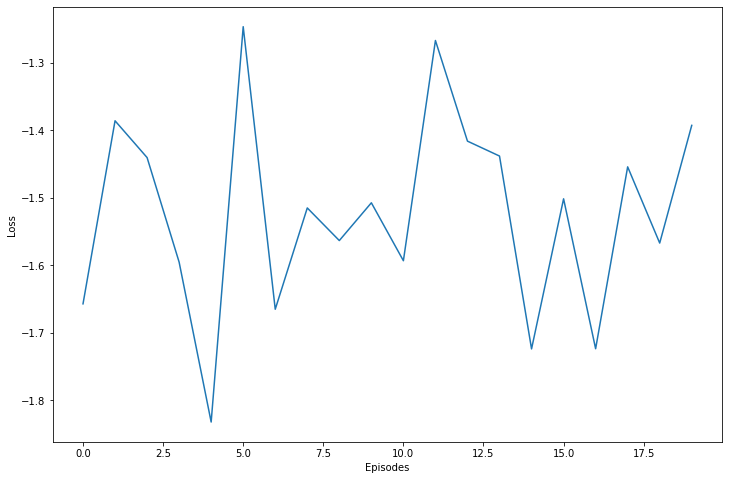

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(loss_hist)
plt.ylabel('Loss')
plt.xlabel('Episodes')
plt.show()